In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trainer
from trainer import device

In [4]:
import os
import PIL.Image

class ImageDataset(D.Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.files = [root + "/" + f for root, _, files in os.walk(path) for f in files]
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = PIL.Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, img

In [5]:
def display(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.axis('off')

def displayn(imgp):
    f, ax = plt.subplots(1, len(imgp), figsize=(3*len(imgp),3))
    for i, (img, label) in enumerate(imgp):
        ax[i].set_title(label)
        ax[i].imshow(img.permute(1,2,0))
        ax[i].axis('off')

In [6]:
import torchvision.transforms as T

def img_resize(img, aug=None):
    img = T.functional.to_tensor(img)
    img = T.functional.resize(img, 256, antialias=False)
    img = T.functional.pad(img, 64, padding_mode='edge')
    if aug:
        img = aug(img)
    img = T.functional.center_crop(img, 256)
    return img

def img_augment(img):
    r = torch.rand((8,))

    img = T.functional.affine(img, angle=r[0].item()*10-5, translate=(int(r[1].item()*20-10), int(r[2].item()*20-10)), scale=r[3].item()*0.1+0.95, shear=0)
    img = T.functional.adjust_brightness(img, r[4].item()*0.1+0.95)
    img = T.functional.adjust_contrast(img, r[5].item()*0.1+0.95)
    img = T.functional.adjust_hue(img, r[6].item()*0.1-0.05)
    img = T.functional.adjust_saturation(img, r[7].item()*0.1+0.95)
    return img

dataset = ImageDataset('../img_align_celeba', transform=lambda img: img_resize(img))
dataset_aug = ImageDataset('../img_align_celeba', transform=lambda img: img_resize(img, img_augment))

In [7]:
class FaceNet(nn.Module):
    def __init__(self, n_hidden=256, n_embed=128):
        super().__init__()
        assert(n_hidden % 8 == 0)
        # encoder is following VGG-11
        self.encoder = nn.Sequential(
            # 256^2 => 128^2
            nn.Conv2d(3, n_hidden//8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 128^2 => 64^2
            nn.Conv2d(n_hidden//8, n_hidden//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 64^2 => 32^2
            nn.Conv2d(n_hidden//4, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden//2, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 32^2 => 16^2
            nn.Conv2d(n_hidden//2, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 16^2 => 8^2
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 8^2 => embedding
            nn.Flatten(-3), # BxCxHxW => BxC*H*W
            nn.Linear(8*8*n_hidden, n_embed)
        )
        # decoder is reversing the encoding process ~exactly
        self.decoder = nn.Sequential(
            nn.Linear(n_embed, 8*8*n_hidden),
            nn.ReLU(inplace=True),
            nn.Unflatten(-1, (n_hidden, 8, 8)),
            # 8^2 => 16^2
            nn.ConvTranspose2d(n_hidden, n_hidden, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 16^2 => 32^2
            nn.ConvTranspose2d(n_hidden, n_hidden, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 32^2 => 64^2
            nn.ConvTranspose2d(n_hidden//2, n_hidden//2, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//2, n_hidden//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_hidden//2, n_hidden//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 64^2 => 128^2
            nn.ConvTranspose2d(n_hidden//4, n_hidden//4, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//4, n_hidden//8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 128^2 => 256^2
            nn.ConvTranspose2d(n_hidden//8, n_hidden//8, kernel_size=2, stride=2),
            nn.Conv2d(n_hidden//8, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid() # => 0..1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def loss(self, p, y):
        return F.mse_loss(p, y)

Train [9.434M params]: 150 epochs took 4045.57 sec, train loss 0.006180, val loss 0.000000


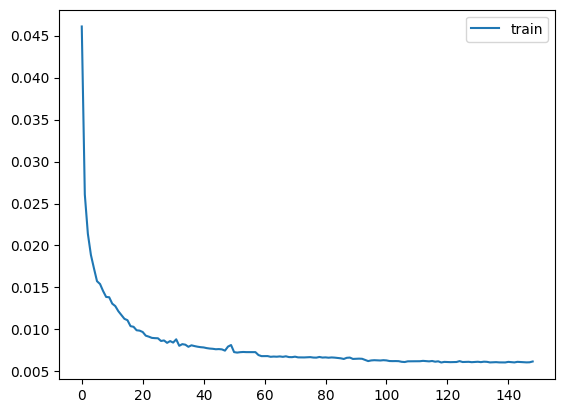

In [8]:
net = FaceNet().to(device)
# not using augmentation atm as it's rather slow :-/
trainer.train(net, D.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True), batch_limit=100, epochs=150)

[41544, 151026]


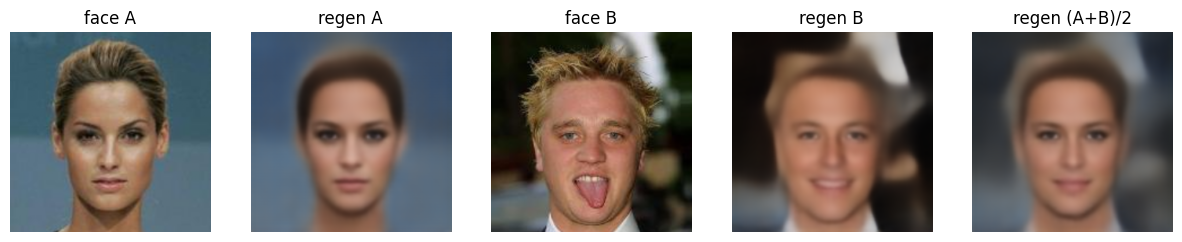

In [90]:
dsl = len(dataset)

for p in [torch.randint(dsl, (2,)).tolist()]:
    print(p)
    x1 = dataset[p[0]][0]
    e1 = net.encoder(x1.to(device))
    y1 = net.decoder(e1).cpu().detach()

    x2 = dataset[p[1]][0]
    e2 = net.encoder(x2.to(device))
    y2 = net.decoder(e2).cpu().detach()

    y12 = net.decoder((e1+e2)/2).cpu().detach()

    displayn([(x1, "face A"), (y1, "regen A"), (x2, "face B"), (y2, "regen B"), (y12, "regen (A+B)/2")])

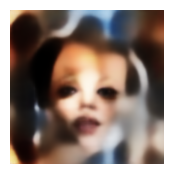

In [106]:
dsl = len(dataset)
es = []

for p in torch.randint(dsl, (100,)).tolist():
    x = dataset[p][0]
    e = net.encoder(x.to(device))
    es.append(e)

em = torch.stack(es).mean(0)
es = torch.stack(es).std(0)

yr = net.decoder(torch.normal(em, es).to(device))
display(yr.cpu().detach())
